In [1]:
import os

import pandas as pd
import re

import random

import Neuron_analysis as na

import plotly
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [2]:
results_dir= 'D:/Complete_points/'

In [3]:
files= os.listdir(results_dir)

## Plots all downsampled points into same space ##

In [6]:
axons=[os.path.join(results_dir,i) for i in files if '_axons.csv' in i]

In [7]:
data_pd=pd.read_csv(axons[0])
data_pd.loc[100:105]

,x,y,z,atlas_ID
100,90,51,256,981
101,91,50,255,981
102,91,50,257,981
103,90,50,257,981
104,89,50,257,981
105,92,50,257,981


In [8]:
fig=go.Figure()

for count,names in enumerate(axons):
    data_pd=pd.read_csv(names)
    name= re.search('\D{2}[0-9]{3}', names)[0]
    
    data_pd['name']= [na.give_me_name(i) for i in data_pd['atlas_ID']]
    data_pd['ML']= [na.stereotaxis(i,ml=1) for i in data_pd['x']]
    data_pd['AP']= [na.stereotaxis(i,ml=0) for i in data_pd['z']]
    data_pd['DV']= [i*25/1000 for i in data_pd['y']]
    
    fig.add_trace(go.Scatter3d( 
        x=data_pd['ML'],
        y=data_pd['DV'],
        z=data_pd['AP'],
        
        mode='markers',
        name=name,
        marker=dict(
            size=1,
            color=count,
            opacity=0.5
        ),
        
        text=data_pd['name'],
        hovertemplate= '%{text}<br> ML: %{x} mm <br> AP: %{z} mm'
        
    ))

camera = dict(
        eye=dict(x=0, y=-1, z=0)
    )

    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Medial-lateral',
                        yaxis_title='Dorsal-ventral',
                        zaxis_title='Anterior-posterior'))
plot(fig,filename=results_dir+'allprojection3d.html')

'D:/Complete_points/allprojection3d.html'

## Plots the individual original points with associated ID ##

In [9]:
ori_points=[os.path.join(results_dir,i) for i in files if 'oripoints' in i]
ori_points

['D:/Complete_points/AL110D_oripoints_withID.csv',
 'D:/Complete_points/AL110_oripoints_withID.csv',
 'D:/Complete_points/AL126D_oripoints_withID.csv',
 'D:/Complete_points/AL126_oripoints_withID.csv',
 'D:/Complete_points/AL131D_oripoints_withID.csv',
 'D:/Complete_points/AL131_oripoints_withID.csv',
 'D:/Complete_points/AL140D_oripoints_withID.csv',
 'D:/Complete_points/AL140_oripoints_withID.csv',
 'D:/Complete_points/AL142D_oripoints_withID.csv',
 'D:/Complete_points/AL142_oripoints_withID.csv',
 'D:/Complete_points/AL157D_oripoints_withID.csv',
 'D:/Complete_points/AL157_oripoints_withID.csv',
 'D:/Complete_points/GF243D_oripoints_withID.csv',
 'D:/Complete_points/GF243_oripoints_withID.csv']

In [14]:
axons=pd.read_csv(ori_points[9])
axons['name']= [na.give_me_name(i) for i in axons['atlasID']]
dendrites=pd.read_csv(ori_points[8])
dendrites['name']= [na.give_me_name(i) for i in dendrites['atlasID']]
mousename=na.find_mousename(ori_points[9])

In [15]:
mousename

'AL142'

In [16]:
def make_scatter(axons, dendrites, mousename):
        
    fig=go.Figure()
    fig.add_trace(go.Scatter3d( 
        x=axons[::3]['x'],
        y=axons[::3]['y'],
        z=axons[::3]['z'],
        mode='markers',
        name='Axons',
        marker=dict(
            size=1,
            color='blue',
            opacity=0.5
        ),
        hovertext= axons[::3]['name'],
        hoverinfo='text'
    ))
    
    fig.add_trace(go.Scatter3d(
        x=dendrites['x'],
        y=dendrites['y'],
        z=dendrites['z'],
        mode='markers',
        name='Dendrites',
        marker=dict(
            size=2,
            color='red',
            opacity=0.5),
        hovertext= dendrites['name'],
        hoverinfo='text'
    ))

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
    camera = dict(
            eye=dict(x=0, y=-1, z=0))
    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
    fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Medial-lateral',
                        yaxis_title='Dorsal-ventral',
                        zaxis_title='Anterior-posterior'))
        
    plot(fig,filename='D:/'+ mousename+'/3Dplot.html')
    

In [17]:
make_scatter(axons,dendrites,mousename)

## Makes individual bar graph ##

In [18]:
files=[os.path.join('D:\\Complete_points\\' ,i) for i in files if 'region_with_counts' in i]

In [19]:
test= [i for i in files if re.search('AL157', i) ]
axon= test[0]
dendrite=test[1]
mousename=na.find_mousename(axon)

In [20]:
axon_bar=pd.read_excel(axon).sort_values(by=['Total_counts'])
dendrite_bar=pd.read_excel(dendrite).sort_values(by=['Total_counts'])

In [21]:
def plot_hist(pd_axon, pd_dendrite, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, mousename
    '''
    y=pd_axon['acronym']
    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=2,
        row_heights=[0.9, 0.1],
        column_titles=['Length (um)','# of endings'], 
        row_titles=['Axons', 'Dendrites'],
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts'], 
        marker_color='olive',
        name='',
        text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Endings_counts'],
        marker_color='seagreen',
        name='',
        text=pd_axon['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=1,col=2
    )

    z=pd_dendrite['acronym']
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Total_counts'], 
        marker_color='blue',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Endings_counts'],
        marker_color='lightblue',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=2
    )
    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      title='Annotations in respective brain regions',
                      height=800
                     )
    fig.show()
    plotly.offline.plot(fig,filename='D:/'+ mousename+'/barplot.html')

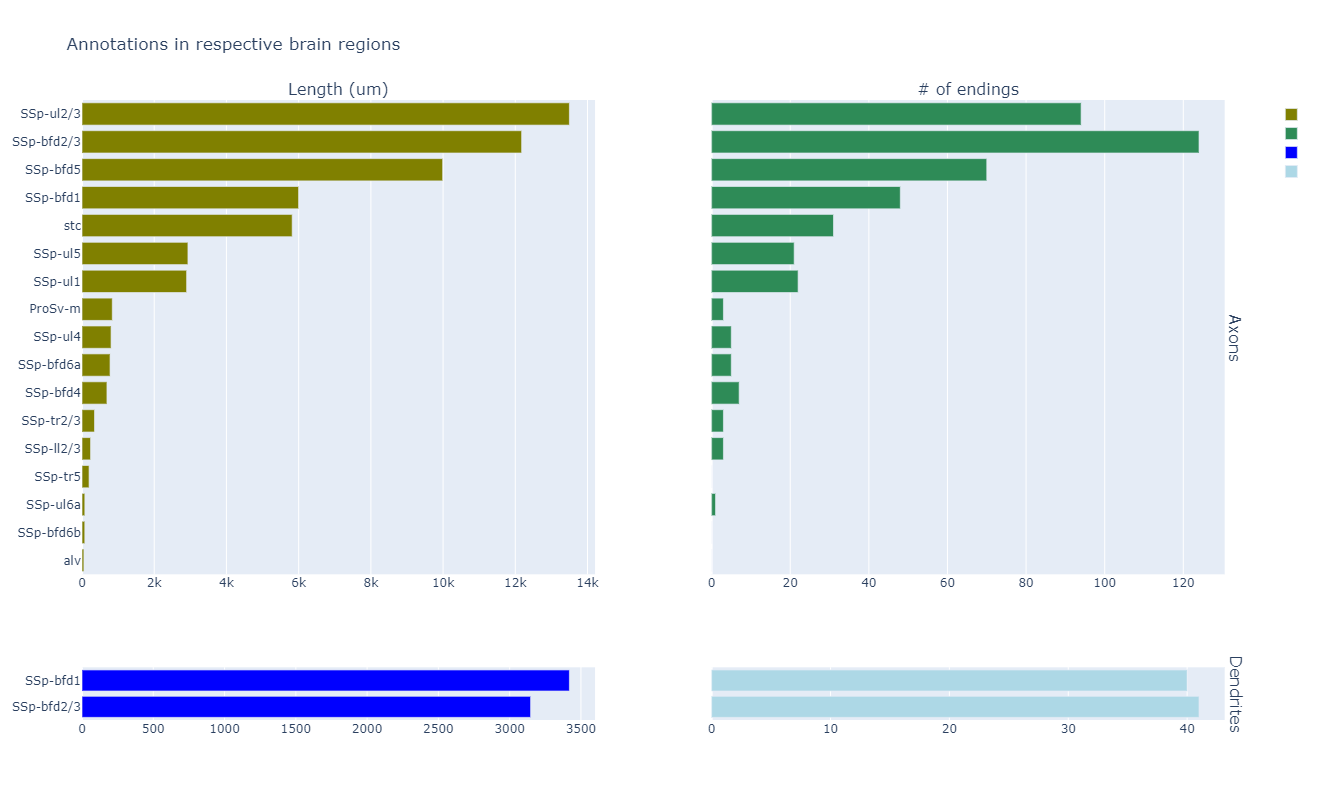

In [22]:
plot_hist(axon_bar,dendrite_bar,mousename)